In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import wandb
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from matplotlib import font_manager

font_dirs = ["./"]
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)
    
sns.set( font = "Helvetica" )

api = wandb.Api()

data_name = 'replogle_rpe1_gw_filtered_hvg'

# Project is specified by <entity/project-name>
runs = api.runs("kexinhuang/" + data_name)

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs = api.runs("kexinhuang/linear_model")

summary_list, config_list, name_list = [], [], []
for run in runs: 
    # .summary contains the output keys/values for metrics like accuracy.
    #  We call ._json_dict to omit large files 
    summary_list.append(run.summary._json_dict)

    # .config contains the hyperparameters.
    #  We remove special values that start with _.
    config_list.append(
        {k: v for k,v in run.config.items()
          if not k.startswith('_')})

    # .name is the human-readable name of the run.
    name_list.append(run.name)

runs_df_linear = pd.DataFrame({
    "summary": summary_list,
    "config": config_list,
    "name": name_list
    })

runs_df = runs_df.append(runs_df_linear)

In [3]:
run = 6
cpa_runs = ['CPA_seed' + str(i) for i in range(1, run)]
pertnet_runs = ['gears_seed' + str(i) for i in range(1, run)]
no_perturb_runs = ['no_perturb_seed' + str(i) for i in range(1, run)]
linear_runs = [data_name + '_' + str(i) for i in range(1, run)]

In [4]:
res_df = runs_df[runs_df.name.isin(cpa_runs + pertnet_runs + no_perturb_runs + linear_runs)]

In [5]:
def normalize_name(x):
    if x in cpa_runs:
        return 'CPA'
    elif x in pertnet_runs:
        return 'GEARS'
    elif x in linear_runs:
        return 'GRN'
    else:
        return 'No-Perturb'

In [6]:
metrics = ['test_mse_top20_de_non_dropout', 'test_pearson_delta']
metrics_name_map = {'test_mse_top20_de_non_dropout': 'Top 20 DE MSE',
                   'test_pearson_delta': 'Pearson Correlation Across All Genes'}
out = {}
out['method'] = [normalize_name(i) for i in res_df.name.values]
for m in metrics:
    out[metrics_name_map[m]] = res_df.summary.apply(lambda x: x[m])
out = pd.DataFrame(out)

In [7]:
color_pal = {
'GRN': (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
'CPA': (0.4, 0.7607843137254902, 0.6470588235294118),
'GEARS': (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
'No-Perturb': (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)}

In [8]:
pal_order = [color_pal[i] for i in pd.DataFrame(out).method.unique()]

In [9]:
import numpy as np
normalize = np.mean(out[out.method == 'No-Perturb']['Top 20 DE MSE'])
out['Normalized MSE of Top 20 DE Genes'] = out['Top 20 DE MSE'].values/normalize

/dfs/user/yhr/deepamp/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


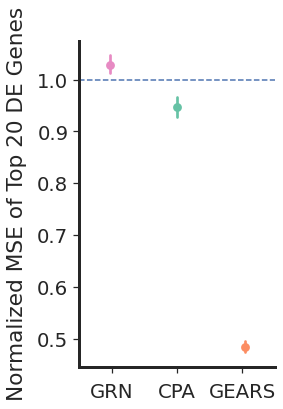

In [22]:
sns.set(rc={'figure.figsize':(3.5,6)})
sns.set_theme(style="ticks", rc={"axes.facecolor": (0, 0, 0, 0)}, font = "Helvetica", font_scale=1.8)

g = sns.pointplot('method', 'Normalized MSE of Top 20 DE Genes', 
    data=pd.DataFrame(out), 
    order = ['GRN','CPA', 'GEARS'], 
    hue = 'method',
    palette=[color_pal['GRN'], color_pal['CPA'], color_pal['GEARS']],              
    dodge=True, 
    join=False,
    hue_order = ['GRN', 'CPA', 'GEARS'],)
sns.despine()
g.legend_.remove()
g.set(xlabel=None)
g.axhline(1, linestyle="dashed")

plt.ylabel("Normalized MSE of Top 20 DE Genes",labelpad=10)
plt.tick_params(axis='x', which='major', pad=10)
plt.tick_params(axis='y', which='major', pad=5)
g.spines['left'].set_linewidth(3)
g.spines['bottom'].set_linewidth(3)
plt.savefig('Fig2b_' + data_name + '.svg', bbox_inches='tight')
